##### 라이브러리

##### 라이브러리 설치

In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


##### 라이브러리 불러오기

In [2]:
import pandas as pd
import ast

##### 옵션

In [3]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

# 기사 데이터 정리 및 통계

### 1. 전체 기사 일자별 카운트

##### 삼성전자 뉴스 csv 불러오기

In [4]:
df_news = pd.read_csv("naver_news/naver_news_20230801_20230831.csv")
df_news.head()

,date,category,title,content,reaction
0,2023-08-01 01:15:00,세계,"니제르 쿠데타 군부 ""프랑스, 군사개입 공모"" 비난(종합)","전임 대통령 아들 포함 각료 4명·여당 대표 체포 중재 나선 차드 수반, '억류중'...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
1,2023-08-01 01:20:00,세계,"Trilateral summit of S. Korea, Japan, U.S. to ...",S Korea-US-Japan Trilateral summit of S. Korea...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
2,2023-08-01 01:26:00,정치,"필리핀 간 EU 수장, 中겨냥 작심발언…""불법 무력사용 용인불가""(종합)",신냉전 전 속 美 이어 EU도 필리핀과 관계 개선 모색…FTA 협상 재개키로 정빛...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': 5, '분석탁월': ..."
3,2023-08-01 02:10:00,세계,"머스크 엑스, SNS연구단체에 소송 위협…""광고주 몰아내려 음모""","엑스 ""CCDH, 우리 경쟁사서 자금지원 받아""…CCDH ""비판에 재갈 물리려는 것...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
4,2023-08-01 02:11:00,세계,"러 가스차단 겪은 유럽, '우라늄대국' 니제르 쿠데타에 전전긍긍","EU 우라늄 수입 20% 차지…원전 의존도 높은 프랑스도 '벌벌' ""니제르 사태 악...","{'쏠쏠정보': 3, '흥미진진': '0', '공감백배': 3, '분석탁월': 2,..."


##### date 열 데이터 변경

In [5]:
df_news["date"] = df_news["date"].apply(lambda x: x.split()[0].replace("-", ""))
df_news.head()

,date,category,title,content,reaction
0,20230801,세계,"니제르 쿠데타 군부 ""프랑스, 군사개입 공모"" 비난(종합)","전임 대통령 아들 포함 각료 4명·여당 대표 체포 중재 나선 차드 수반, '억류중'...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
1,20230801,세계,"Trilateral summit of S. Korea, Japan, U.S. to ...",S Korea-US-Japan Trilateral summit of S. Korea...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
2,20230801,정치,"필리핀 간 EU 수장, 中겨냥 작심발언…""불법 무력사용 용인불가""(종합)",신냉전 전 속 美 이어 EU도 필리핀과 관계 개선 모색…FTA 협상 재개키로 정빛...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': 5, '분석탁월': ..."
3,20230801,세계,"머스크 엑스, SNS연구단체에 소송 위협…""광고주 몰아내려 음모""","엑스 ""CCDH, 우리 경쟁사서 자금지원 받아""…CCDH ""비판에 재갈 물리려는 것...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
4,20230801,세계,"러 가스차단 겪은 유럽, '우라늄대국' 니제르 쿠데타에 전전긍긍","EU 우라늄 수입 20% 차지…원전 의존도 높은 프랑스도 '벌벌' ""니제르 사태 악...","{'쏠쏠정보': 3, '흥미진진': '0', '공감백배': 3, '분석탁월': 2,..."


##### 전체 기사 일자별 카운트

In [6]:
all = []
for day in range(1, 32):
    date_str = f"202308{day:02d}"
    count_all = len(df_news.loc[df_news["date"] == date_str])
    all.append({"날짜":date_str, "전체":count_all})

all

[{'날짜': '20230801', '전체': 939},
 {'날짜': '20230802', '전체': 1012},
 {'날짜': '20230803', '전체': 1119},
 {'날짜': '20230804', '전체': 854},
 {'날짜': '20230805', '전체': 381},
 {'날짜': '20230806', '전체': 552},
 {'날짜': '20230807', '전체': 839},
 {'날짜': '20230808', '전체': 1059},
 {'날짜': '20230809', '전체': 1034},
 {'날짜': '20230810', '전체': 1176},
 {'날짜': '20230811', '전체': 841},
 {'날짜': '20230812', '전체': 251},
 {'날짜': '20230813', '전체': 414},
 {'날짜': '20230814', '전체': 863},
 {'날짜': '20230815', '전체': 526},
 {'날짜': '20230816', '전체': 1029},
 {'날짜': '20230817', '전체': 1044},
 {'날짜': '20230818', '전체': 855},
 {'날짜': '20230819', '전체': 287},
 {'날짜': '20230820', '전체': 428},
 {'날짜': '20230821', '전체': 877},
 {'날짜': '20230822', '전체': 997},
 {'날짜': '20230823', '전체': 1094},
 {'날짜': '20230824', '전체': 1265},
 {'날짜': '20230825', '전체': 838},
 {'날짜': '20230826', '전체': 238},
 {'날짜': '20230827', '전체': 380},
 {'날짜': '20230828', '전체': 943},
 {'날짜': '20230829', '전체': 1101},
 {'날짜': '20230830', '전체': 1086},
 {'날짜': '20230831', '전체': 111

##### 데이터프레임 생성

In [7]:
count_all = pd.DataFrame(all)
count_all.head()

,날짜,전체
0,20230801,939
1,20230802,1012
2,20230803,1119
3,20230804,854
4,20230805,381


### 2. 본문이 비어있는 기사 등을 제외하고 크롤링한 기사 중 본문에 삼성전자 글자가 들어간 뉴스 분류

##### content 열에 NaN 값 제거

In [8]:
df_news.dropna(subset=["content"], inplace=True)
df_news.head()

,date,category,title,content,reaction
0,20230801,세계,"니제르 쿠데타 군부 ""프랑스, 군사개입 공모"" 비난(종합)","전임 대통령 아들 포함 각료 4명·여당 대표 체포 중재 나선 차드 수반, '억류중'...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
1,20230801,세계,"Trilateral summit of S. Korea, Japan, U.S. to ...",S Korea-US-Japan Trilateral summit of S. Korea...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
2,20230801,정치,"필리핀 간 EU 수장, 中겨냥 작심발언…""불법 무력사용 용인불가""(종합)",신냉전 전 속 美 이어 EU도 필리핀과 관계 개선 모색…FTA 협상 재개키로 정빛...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': 5, '분석탁월': ..."
3,20230801,세계,"머스크 엑스, SNS연구단체에 소송 위협…""광고주 몰아내려 음모""","엑스 ""CCDH, 우리 경쟁사서 자금지원 받아""…CCDH ""비판에 재갈 물리려는 것...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
4,20230801,세계,"러 가스차단 겪은 유럽, '우라늄대국' 니제르 쿠데타에 전전긍긍","EU 우라늄 수입 20% 차지…원전 의존도 높은 프랑스도 '벌벌' ""니제르 사태 악...","{'쏠쏠정보': 3, '흥미진진': '0', '공감백배': 3, '분석탁월': 2,..."


##### 'content' 열의 데이터에 '삼성전자'가 포함된 행을 필터링하여 날짜별 개수 카운트

In [9]:
df_samsung = df_news[df_news["content"].str.contains("삼성전자")].groupby("date").size().reset_index(name="본문")
df_samsung.head()

,date,본문
0,20230801,15
1,20230802,5
2,20230803,4
3,20230804,6
4,20230806,4


### 3. 삼성 주가데이터 합체 및 주가데이터가 없는 날짜 정리

##### 삼성전자 주식 csv 불러오기

In [10]:
df_stock = pd.read_csv("naver_stock/naver_stock_20230801_20230831.csv")
df_stock.head()

,date,end_price,change,start_price,high_price,low_price,volume
0,2023-08-01 00:00:00,"71,100","상승 1,300","70,100","71,200","70,000","12,299,254"
1,2023-08-02 00:00:00,"69,900","하락 1,200","70,700","71,000","69,800","13,835,020"
2,2023-08-03 00:00:00,"68,800","하락 1,100","69,900","70,200","68,500","20,087,090"
3,2023-08-04 00:00:00,"68,300",하락 500,"68,800","69,100","68,200","12,360,193"
4,2023-08-07 00:00:00,"68,500",상승 200,"67,700","69,200","67,600","10,968,505"


##### date 열 데이터 변경

In [11]:
df_stock["date"] = df_stock["date"].apply(lambda x: x.split()[0].replace("-", ""))
df_stock.head()

,date,end_price,change,start_price,high_price,low_price,volume
0,20230801,"71,100","상승 1,300","70,100","71,200","70,000","12,299,254"
1,20230802,"69,900","하락 1,200","70,700","71,000","69,800","13,835,020"
2,20230803,"68,800","하락 1,100","69,900","70,200","68,500","20,087,090"
3,20230804,"68,300",하락 500,"68,800","69,100","68,200","12,360,193"
4,20230807,"68,500",상승 200,"67,700","69,200","67,600","10,968,505"


##### end_price 열 데이터 형식 변경

In [12]:
df_stock["end_price"] = df_stock["end_price"].str.replace(",", "").astype(float)
df_stock.head()

,date,end_price,change,start_price,high_price,low_price,volume
0,20230801,71100.0,"상승 1,300","70,100","71,200","70,000","12,299,254"
1,20230802,69900.0,"하락 1,200","70,700","71,000","69,800","13,835,020"
2,20230803,68800.0,"하락 1,100","69,900","70,200","68,500","20,087,090"
3,20230804,68300.0,하락 500,"68,800","69,100","68,200","12,360,193"
4,20230807,68500.0,상승 200,"67,700","69,200","67,600","10,968,505"


##### df_stock에서 date와 end_price 열만 선택

In [13]:
df_stock_subset = df_stock[["date", "end_price"]]
df_stock_subset.head()

,date,end_price
0,20230801,71100.0
1,20230802,69900.0
2,20230803,68800.0
3,20230804,68300.0
4,20230807,68500.0


##### df_stock의 날짜를 기준으로 데이터프레임 병합

In [14]:
samsung = pd.merge(df_stock_subset, df_samsung, on="date", how="left")
samsung.head()

,date,end_price,본문
0,20230801,71100.0,15
1,20230802,69900.0,5
2,20230803,68800.0,4
3,20230804,68300.0,6
4,20230807,68500.0,4


##### 열 이름 변경

In [15]:
samsung = samsung.rename(columns={"date":"날짜", "end_price":"주가"})
samsung.head()

,날짜,주가,본문
0,20230801,71100.0,15
1,20230802,69900.0,5
2,20230803,68800.0,4
3,20230804,68300.0,6
4,20230807,68500.0,4


##### 데이터프레임 열 순서 변경

In [16]:
samsung = samsung[["날짜", "본문", "주가"]]
samsung

,날짜,본문,주가
0,20230801,15,71100.0
1,20230802,5,69900.0
2,20230803,4,68800.0
3,20230804,6,68300.0
4,20230807,4,68500.0
5,20230808,11,67600.0
6,20230809,16,68900.0
7,20230810,2,68000.0
8,20230811,7,67500.0
9,20230814,6,67300.0


##### 인덱스 재설정

In [17]:
samsung.set_index("날짜", inplace=True)
samsung

,본문,주가
날짜,,
20230801,15,71100.0
20230802,5,69900.0
20230803,4,68800.0
20230804,6,68300.0
20230807,4,68500.0
20230808,11,67600.0
20230809,16,68900.0
20230810,2,68000.0
20230811,7,67500.0


### 4. 수치를 백분위로 변경 ((날짜별 합 / 전체 합) * 100)

##### 본문 백분위

In [18]:
samsung["본문 백분위"] = (samsung["본문"] / samsung["본문"].sum()) * 100
samsung

,본문,주가,본문 백분위
날짜,,,
20230801,15,71100.0,8.241758
20230802,5,69900.0,2.747253
20230803,4,68800.0,2.197802
20230804,6,68300.0,3.296703
20230807,4,68500.0,2.197802
20230808,11,67600.0,6.043956
20230809,16,68900.0,8.791209
20230810,2,68000.0,1.098901
20230811,7,67500.0,3.846154


##### 삼성전자 주가 백분위

In [19]:
samsung["삼성전자 주가 백분위"] = (samsung["주가"] / samsung["주가"].sum()) * 100
samsung

,본문,주가,본문 백분위,삼성전자 주가 백분위
날짜,,,,
20230801,15,71100.0,8.241758,4.774696
20230802,5,69900.0,2.747253,4.694111
20230803,4,68800.0,2.197802,4.620240
20230804,6,68300.0,3.296703,4.586663
20230807,4,68500.0,2.197802,4.600094
20230808,11,67600.0,6.043956,4.539655
20230809,16,68900.0,8.791209,4.626956
20230810,2,68000.0,1.098901,4.566517
20230811,7,67500.0,3.846154,4.532939


# 관심도, 카테고리 데이터 통계

### 1. 삼성전자 기사 날짜별 관심도 정리

##### 본문에 삼성전자가 들어간 기사 추출

In [20]:
df_samsung = df_news[df_news["content"].str.contains("삼성전자")]
df_samsung.head()

,date,category,title,content,reaction
29,20230801,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."
60,20230801,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
62,20230801,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0..."
66,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
67,20230801,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."


##### 인덱스 재설정

In [21]:
df_samsung.set_index("date", inplace=True)
df_samsung.head()

,category,title,content,reaction
date,,,,
20230801,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."
20230801,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
20230801,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0..."
20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
20230801,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."


##### 날짜별 기사 반응 합계 추출

In [22]:
reactions = {}

for date, dict in df_samsung["reaction"].items():
    reactions_dict = ast.literal_eval(dict)     # 문자열을 딕셔너리로 변환
    reaction_count = 0
    
    # 각 반응에 대해 숫자로 변환하여 더하기
    for count in reactions_dict.values():
        if isinstance(count, int):  # 값이 정수인 경우에만 처리
            reaction_count += count
            
    reactions[date] = reaction_count    # 각 날짜별 총 반응 수를 딕셔너리에 저장
    
reactions

{'20230801': 14,
 '20230802': 1,
 '20230803': 0,
 '20230804': 0,
 '20230806': 11,
 '20230807': 0,
 '20230808': 3,
 '20230809': 4,
 '20230810': 0,
 '20230811': 0,
 '20230812': 1,
 '20230813': 2,
 '20230814': 5,
 '20230815': 4,
 '20230816': 0,
 '20230817': 3,
 '20230818': 2,
 '20230820': 0,
 '20230821': 2,
 '20230822': 1,
 '20230823': 0,
 '20230824': 1,
 '20230825': 0,
 '20230826': 12,
 '20230827': 3,
 '20230828': 0,
 '20230829': 0,
 '20230830': 1,
 '20230831': 0}

##### 딕셔너리를 데이터프레임으로 변환

In [23]:
df_reaction = pd.DataFrame(list(reactions.items()), columns=["날짜", "반응도"])
df_reaction

,날짜,반응도
0,20230801,14
1,20230802,1
2,20230803,0
3,20230804,0
4,20230806,11
5,20230807,0
6,20230808,3
7,20230809,4
8,20230810,0
9,20230811,0


##### 인덱스 재설정

In [24]:
df_reaction.set_index("날짜", inplace=True)
df_reaction

,반응도
날짜,
20230801,14
20230802,1
20230803,0
20230804,0
20230806,11
20230807,0
20230808,3
20230809,4
20230810,0


### 2. 삼성전자 기사 카테고리별 합계

##### 삼성전자 기사 추출

In [25]:
df_category = df_news[df_news["content"].str.contains("삼성전자")]
df_category

,date,category,title,content,reaction
29,20230801,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."
60,20230801,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
62,20230801,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0..."
66,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
67,20230801,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
70,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
71,20230801,경제,드론으로 표현한 '갤럭시 Z 폴드5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
77,20230801,경제,"LG전자, 미 컨슈머리포트 선정 '최고의 드럼 세탁기'",LG전자 드럼 세탁기가 미국 소비자들이 선정한 '최고의 드럼 세탁기'에 이름을 ...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
84,20230801,경제,"삼성전자 ""올해 1∼7월 국내 판매 TV 3대 중 1대는 초대형 TV""",'거거익선' 트렌드 가속…7월 98형 판매량 작년 동월 대비 7배 증가 삼성전자...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
155,20230801,IT,SK쉴더스 대표이사 부회장에 홍원표 전 삼성SDS 사장,SK쉴더스는 이사회를 열어 홍원표 전 삼성SDS 사장을 신임 대표이사 부회장으로...,"{'쏠쏠정보': 2, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."


##### category열 이름 변경

In [26]:
df_category.rename(columns={"category":"카테고리"}, inplace=True)
df_category

/var/folders/68/_mk2p_yn3m7d9ql2vw6vlbww0000gn/T/ipykernel_1038/2901468926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category.rename(columns={"category":"카테고리"}, inplace=True)


,date,카테고리,title,content,reaction
29,20230801,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."
60,20230801,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
62,20230801,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0..."
66,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
67,20230801,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
70,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
71,20230801,경제,드론으로 표현한 '갤럭시 Z 폴드5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
77,20230801,경제,"LG전자, 미 컨슈머리포트 선정 '최고의 드럼 세탁기'",LG전자 드럼 세탁기가 미국 소비자들이 선정한 '최고의 드럼 세탁기'에 이름을 ...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
84,20230801,경제,"삼성전자 ""올해 1∼7월 국내 판매 TV 3대 중 1대는 초대형 TV""",'거거익선' 트렌드 가속…7월 98형 판매량 작년 동월 대비 7배 증가 삼성전자...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
155,20230801,IT,SK쉴더스 대표이사 부회장에 홍원표 전 삼성SDS 사장,SK쉴더스는 이사회를 열어 홍원표 전 삼성SDS 사장을 신임 대표이사 부회장으로...,"{'쏠쏠정보': 2, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."


##### 카테고리별 합계

In [27]:
count_category = df_category["카테고리"].value_counts()
count_category

카테고리
경제      129
IT       32
사회       23
세계       14
생활        4
정치        3
스포츠       1
오피니언      1
Name: count, dtype: int64

##### 카테고리별 합계 이름 변경

In [28]:
count_category.name = "본문"
count_category

카테고리
경제      129
IT       32
사회       23
세계       14
생활        4
정치        3
스포츠       1
오피니언      1
Name: 본문, dtype: int64

# 시각화

#### 라이브러리

##### 라이브러리 설치

In [29]:
!pip3 install matplotlib

##### 라이브러리 불러오기

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 1. 기사 버즈량 및 주가 비교 그래프
버즈량: 온라인상 실제 고객들을 통해 언급된 횟수

##### 그래프에 필요한 데이터 불러오기

In [31]:
samsung

,본문,주가,본문 백분위,삼성전자 주가 백분위
날짜,,,,
20230801,15,71100.0,8.241758,4.774696
20230802,5,69900.0,2.747253,4.694111
20230803,4,68800.0,2.197802,4.620240
20230804,6,68300.0,3.296703,4.586663
20230807,4,68500.0,2.197802,4.600094
20230808,11,67600.0,6.043956,4.539655
20230809,16,68900.0,8.791209,4.626956
20230810,2,68000.0,1.098901,4.566517
20230811,7,67500.0,3.846154,4.532939


##### x축 데이터 설정

In [32]:
x = samsung.index
x

Index(['20230801', '20230802', '20230803', '20230804', '20230807', '20230808',
       '20230809', '20230810', '20230811', '20230814', '20230816', '20230817',
       '20230818', '20230821', '20230822', '20230823', '20230824', '20230825',
       '20230828', '20230829', '20230830', '20230831'],
      dtype='object', name='날짜')

##### 기사 버즈량 그래프 y축 데이터 설정

In [33]:
article_y = samsung["본문"].values
article_y

array([15,  5,  4,  6,  4, 11, 16,  2,  7,  6,  7,  2,  6,  4, 16,  8, 14,
       14,  6, 10,  5, 14])

##### 주가 그래프 y축 데이터 설정

In [34]:
stock_y = samsung["주가"].values
stock_y

array([71100., 69900., 68800., 68300., 68500., 67600., 68900., 68000.,
       67500., 67300., 67000., 66700., 66300., 66600., 66600., 67100.,
       68200., 67100., 66800., 66800., 67100., 66900.])

##### 기사 버즈량 및 주가 비교 그래프

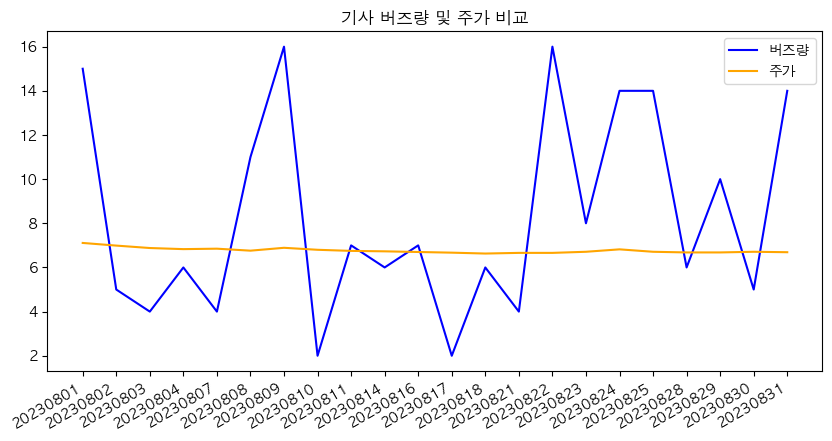

In [35]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# 그래프 제목
ax.set_title('기사 버즈량 및 주가 비교') 

# 기사 버즈량 그래프 설정
ax.plot(x, article_y, 'blue', label='버즈량')

# 주가 그래프 설정
scaled_stock_y = [stock / 10000 for stock in stock_y] # 주가를 10000으로 나누어 스케일 조정 
ax.plot(x, scaled_stock_y, 'orange', label='주가')

fig.autofmt_xdate() # x축 레이블 텍스트 회전
ax.legend() # 범례 설정

plt.show() # 그래프 출력

### 2. 일자별 기사 관심도 그래프

##### 그래프에 필요한 데이터 불러오기

In [36]:
df_reaction

,반응도
날짜,
20230801,14
20230802,1
20230803,0
20230804,0
20230806,11
20230807,0
20230808,3
20230809,4
20230810,0


##### x축 데이터 설정

In [37]:
x = df_reaction.index
x

Index(['20230801', '20230802', '20230803', '20230804', '20230806', '20230807',
       '20230808', '20230809', '20230810', '20230811', '20230812', '20230813',
       '20230814', '20230815', '20230816', '20230817', '20230818', '20230820',
       '20230821', '20230822', '20230823', '20230824', '20230825', '20230826',
       '20230827', '20230828', '20230829', '20230830', '20230831'],
      dtype='object', name='날짜')

##### y축 데이터 설정

In [38]:
y = df_reaction["반응도"].values
y

array([14,  1,  0,  0, 11,  0,  3,  4,  0,  0,  1,  2,  5,  4,  0,  3,  2,
        0,  2,  1,  0,  1,  0, 12,  3,  0,  0,  1,  0])

##### 일자별 기사 관심도 그래프

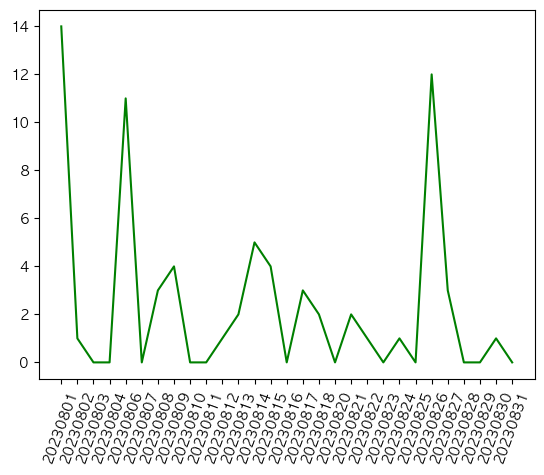

In [39]:
plt.plot(x, y, 'green')

plt.xticks(rotation=70)

plt.show()

### 3. 카테고리별 기사량 그래프

##### 그래프에 필요한 데이터 불러오기

In [40]:
categories = df_category["카테고리"].value_counts()
categories

카테고리
경제      129
IT       32
사회       23
세계       14
생활        4
정치        3
스포츠       1
오피니언      1
Name: count, dtype: int64

##### 카테고리 순서 재정렬

In [41]:
ordered = ['IT', '경제', '사회', '생활', '세계', '스포츠', '오피니언', '정치']
ordered_categories = categories.reindex(ordered)
ordered_categories

카테고리
IT       32
경제      129
사회       23
생활        4
세계       14
스포츠       1
오피니언      1
정치        3
Name: count, dtype: int64

##### x축 데이터 설정

In [42]:
category_x = ordered_categories.index
category_x

Index(['IT', '경제', '사회', '생활', '세계', '스포츠', '오피니언', '정치'], dtype='object', name='카테고리')

In [43]:
category_y = ordered_categories.values
category_y

array([ 32, 129,  23,   4,  14,   1,   1,   3])

##### 카테고리별 기사량 그래프

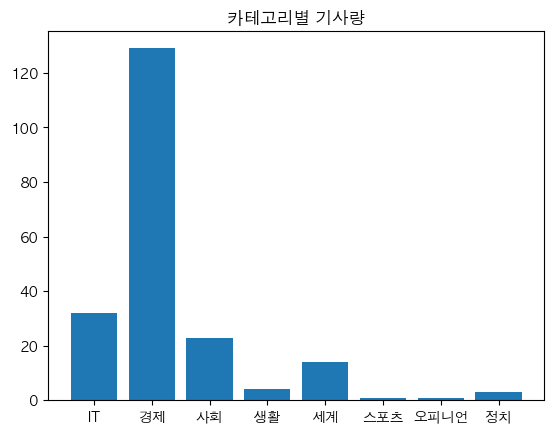

In [44]:
plt.bar(category_x, category_y) # 막대 그래프

plt.title('카테고리별 기사량') # 그래프 제목 설정

plt.show()

# 워드 클라우드

#### 라이브러리

##### 라이브러리 설치

In [45]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


##### 라이브러리 불러오기

In [46]:
from wordcloud import WordCloud, STOPWORDS

### 1. 기사 버즈량이 가장 많은 날 워드 클라우드

##### 기사 버즈량이 가장 많은 날 파악

In [47]:
desc_samsung = samsung.sort_values("본문", ascending=False)
desc_samsung

,본문,주가,본문 백분위,삼성전자 주가 백분위
날짜,,,,
20230809,16,68900.0,8.791209,4.626956
20230822,16,66600.0,8.791209,4.472500
20230801,15,71100.0,8.241758,4.774696
20230825,14,67100.0,7.692308,4.506077
20230824,14,68200.0,7.692308,4.579948
20230831,14,66900.0,7.692308,4.492647
20230808,11,67600.0,6.043956,4.539655
20230829,10,66800.0,5.494505,4.485931
20230823,8,67100.0,4.395604,4.506077


##### 기사 버즈량이 가장 많은 날 기사 본문 추출

In [48]:
desc_news = df_news[df_news["content"].str.contains("삼성전자")] # 삼성전자 포함된 기사 본문 추출
desc_news = desc_news[desc_news["date"] == "20230809"] # 기사 버즈량이 가장 많은 날 기사 추출
words = desc_news["content"].values # 기사 버즈량이 가장 많은 날 기사 본문 추출

##### 워드 클라우드 생성

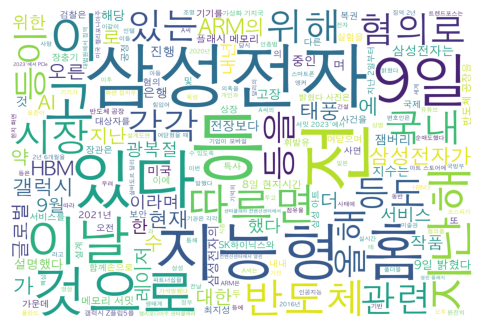

In [49]:
wordcloud = WordCloud(max_font_size = 200, font_path = '/Library/Fonts/AppleGothic', background_color = '#FFFFFF', width = 1200, height = 800).generate(' '.join(words))

plt.figure(figsize=(5, 5)) # 워드 클라우드 사이즈 설정
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

> # stella's opinion
- 기사 버즈량이 가장 많은 날의 기사 본문을 그대로 사용해서 워드클라우드를 생성해보니, 불필요한 단어들이 너무 많이 포함되어 있음을 파악.
- 핵심 키워드 추출을 위해서는 텍스트 마이닝이 선행되어야 한다고 판단.
    - 불필요한 데이터 제거
    - 형태소 분석

# 텍스트 마이닝

### 불필요한 데이터(결측값, 중복) 제거

##### 원본 데이터 불러오기

In [50]:
df = pd.read_csv('naver_news/naver_news_20230801_20230831.csv')
df.head()

,date,category,title,content,reaction
0,2023-08-01 01:15:00,세계,"니제르 쿠데타 군부 ""프랑스, 군사개입 공모"" 비난(종합)","전임 대통령 아들 포함 각료 4명·여당 대표 체포 중재 나선 차드 수반, '억류중'...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
1,2023-08-01 01:20:00,세계,"Trilateral summit of S. Korea, Japan, U.S. to ...",S Korea-US-Japan Trilateral summit of S. Korea...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
2,2023-08-01 01:26:00,정치,"필리핀 간 EU 수장, 中겨냥 작심발언…""불법 무력사용 용인불가""(종합)",신냉전 전 속 美 이어 EU도 필리핀과 관계 개선 모색…FTA 협상 재개키로 정빛...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': 5, '분석탁월': ..."
3,2023-08-01 02:10:00,세계,"머스크 엑스, SNS연구단체에 소송 위협…""광고주 몰아내려 음모""","엑스 ""CCDH, 우리 경쟁사서 자금지원 받아""…CCDH ""비판에 재갈 물리려는 것...","{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
4,2023-08-01 02:11:00,세계,"러 가스차단 겪은 유럽, '우라늄대국' 니제르 쿠데타에 전전긍긍","EU 우라늄 수입 20% 차지…원전 의존도 높은 프랑스도 '벌벌' ""니제르 사태 악...","{'쏠쏠정보': 3, '흥미진진': '0', '공감백배': 3, '분석탁월': 2,..."


##### 결측값 확인

In [51]:
# 각 열마다 존재하는 결측값 개수 카운트
df.isnull().sum()

date          0
category    121
title         0
content     323
reaction      0
dtype: int64

##### 결측값 제거

In [52]:
df.dropna(inplace=True)

##### 중복 확인

In [53]:
df['content'].nunique()

21750

##### 중복 데이터 제거

In [54]:
df.drop_duplicates(subset=['content'], inplace=True)
len(df)

21750

##### 삼성전자가 포함된 본문 추출

In [55]:
df = df[df['content'].str.contains('삼성전자')]
df

,date,category,title,content,reaction
29,2023-08-01 06:01:00,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."
60,2023-08-01 08:14:00,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
62,2023-08-01 08:16:00,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0..."
66,2023-08-01 08:27:00,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
67,2023-08-01 08:28:00,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
70,2023-08-01 08:29:00,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
71,2023-08-01 08:29:00,경제,드론으로 표현한 '갤럭시 Z 폴드5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
77,2023-08-01 08:38:00,경제,"LG전자, 미 컨슈머리포트 선정 '최고의 드럼 세탁기'",LG전자 드럼 세탁기가 미국 소비자들이 선정한 '최고의 드럼 세탁기'에 이름을 ...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
84,2023-08-01 08:49:00,경제,"삼성전자 ""올해 1∼7월 국내 판매 TV 3대 중 1대는 초대형 TV""",'거거익선' 트렌드 가속…7월 98형 판매량 작년 동월 대비 7배 증가 삼성전자...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
155,2023-08-01 09:39:00,IT,SK쉴더스 대표이사 부회장에 홍원표 전 삼성SDS 사장,SK쉴더스는 이사회를 열어 홍원표 전 삼성SDS 사장을 신임 대표이사 부회장으로...,"{'쏠쏠정보': 2, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."


##### 날짜 형식 변경

In [56]:
df['date'] = df['date'].apply(lambda x: x.split()[0].replace('-', ''))

##### 최종 데이터 출력

In [57]:
df

,date,category,title,content,reaction
29,20230801,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."
60,20230801,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
62,20230801,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0..."
66,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
67,20230801,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
70,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
71,20230801,경제,드론으로 표현한 '갤럭시 Z 폴드5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
77,20230801,경제,"LG전자, 미 컨슈머리포트 선정 '최고의 드럼 세탁기'",LG전자 드럼 세탁기가 미국 소비자들이 선정한 '최고의 드럼 세탁기'에 이름을 ...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
84,20230801,경제,"삼성전자 ""올해 1∼7월 국내 판매 TV 3대 중 1대는 초대형 TV""",'거거익선' 트렌드 가속…7월 98형 판매량 작년 동월 대비 7배 증가 삼성전자...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'..."
155,20230801,IT,SK쉴더스 대표이사 부회장에 홍원표 전 삼성SDS 사장,SK쉴더스는 이사회를 열어 홍원표 전 삼성SDS 사장을 신임 대표이사 부회장으로...,"{'쏠쏠정보': 2, '흥미진진': '0', '공감백배': '0', '분석탁월': ..."


#### 형태소 분석기

##### 형태소 분석기 KoNLPy 설치

In [58]:
%pip install konlpy

Note: you may need to restart the kernel to use updated packages.


##### 형태소 분석기 불러오기

In [59]:
from konlpy.tag import Okt

##### 형태소 분석

In [116]:
okt = Okt() # 명사 분석기에 이름 부여

df['tokenized'] = df['content'].apply(okt.nouns)
df

,date,category,title,content,reaction,tokenized
29,20230801,경제,올해 대기업집단 시총 350조원 증가…에코프로그룹 12조→70조,리더스인덱스 분석…삼성전자[005930] 포함 삼성그룹 98조원 증가 리더스인덱스 ...,"{'쏠쏠정보': 1, '흥미진진': '0', '공감백배': '0', '분석탁월': ...","[리더스, 인덱스, 분석, 삼성전자, 포함, 삼성, 그룹, 증가, 리더스, 인덱스,..."
60,20230801,경제,"삼성전자, 2023년 국내 판매 TV 3대 중 1대는 초대형 TV",삼성전자가 올해 1월부터 7월까지 국내에 판매한 Neo QLED·QLED TV 3...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[삼성전자, 올해, 국내, 판매, 중, 형, 이상, 초대형, 로, 집계, 사진, 삼..."
62,20230801,IT,"삼성전자, 부산 광안리서 갤Z5 출시 알리는 드론쇼",삼성전자는 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 개소...,"{'쏠쏠정보': '0', '흥미진진': 1, '공감백배': 4, '분석탁월': '0...","[삼성전자, 갤럭시, 신제품, 체험, 수, 갤럭시, 스튜디오, 부산, 광안리, 개소..."
66,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[삼성전자, 갤럭시, 신제품, 체험, 수, 갤럭시, 스튜디오, 부산, 광안리, 오픈..."
67,20230801,경제,"삼성전자, 갤럭시 스튜디오 오픈 기념 드론 라이트쇼 진행",삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[삼성전자, 갤럭시, 신제품, 체험, 수, 갤럭시, 스튜디오, 부산, 광안리, 오픈..."
70,20230801,경제,드론으로 표현한 '갤럭시 Z 플립5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[삼성전자, 갤럭시, 신제품, 체험, 수, 갤럭시, 스튜디오, 부산, 광안리, 오픈..."
71,20230801,경제,드론으로 표현한 '갤럭시 Z 폴드5',삼성전자가 갤럭시 신제품을 체험할 수 있는 갤럭시 스튜디오 '부산 광안리' 오픈을...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[삼성전자, 갤럭시, 신제품, 체험, 수, 갤럭시, 스튜디오, 부산, 광안리, 오픈..."
77,20230801,경제,"LG전자, 미 컨슈머리포트 선정 '최고의 드럼 세탁기'",LG전자 드럼 세탁기가 미국 소비자들이 선정한 '최고의 드럼 세탁기'에 이름을 ...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[전자, 드럼, 세탁기, 미국, 소비자, 선정, 최고, 드럼, 세탁기, 이름, 업계..."
84,20230801,경제,"삼성전자 ""올해 1∼7월 국내 판매 TV 3대 중 1대는 초대형 TV""",'거거익선' 트렌드 가속…7월 98형 판매량 작년 동월 대비 7배 증가 삼성전자...,"{'쏠쏠정보': '0', '흥미진진': '0', '공감백배': '0', '분석탁월'...","[거거익선, 트렌드, 가속, 형, 판매량, 작년, 동월, 대비, 배, 증가, 삼성전..."
155,20230801,IT,SK쉴더스 대표이사 부회장에 홍원표 전 삼성SDS 사장,SK쉴더스는 이사회를 열어 홍원표 전 삼성SDS 사장을 신임 대표이사 부회장으로...,"{'쏠쏠정보': 2, '흥미진진': '0', '공감백배': '0', '분석탁월': ...","[쉴더스, 이사회, 홍원, 표, 전, 삼성, 사장, 신임, 대표이사, 부회장, 선임..."


#### 사용자 사전

##### 사용자 사전 경로 확인

In [61]:
import os

os.chdir('/Users/fininsight/anaconda3/envs/stella/lib/python3.11/site-packages/konlpy/java')
os.getcwd()

!jar xvf open-korean-text-2.1.0.jar

  생성됨: META-INF/
 증가됨: META-INF/MANIFEST.MF
  생성됨: org/
  생성됨: org/openkoreantext/
  생성됨: org/openkoreantext/processor/
 증가됨: org/openkoreantext/processor/KoreanPosJava.class
 증가됨: org/openkoreantext/processor/KoreanTokenJava.class
 증가됨: org/openkoreantext/processor/OpenKoreanTextProcessor$.class
 증가됨: org/openkoreantext/processor/OpenKoreanTextProcessor.class
 증가됨: org/openkoreantext/processor/OpenKoreanTextProcessorJava.class
  생성됨: org/openkoreantext/processor/normalizer/
 증가됨: org/openkoreantext/processor/normalizer/KoreanNormalizer$.class
 증가됨: org/openkoreantext/processor/normalizer/KoreanNormalizer$Segment$.class
 증가됨: org/openkoreantext/processor/normalizer/KoreanNormalizer$Segment.class
 증가됨: org/openkoreantext/processor/normalizer/KoreanNormalizer.class
  생성됨: org/openkoreantext/processor/phrase_extractor/
 증가됨: org/openkoreantext/processor/phrase_extractor/KoreanPhraseExtractor$.class
 증가됨: org/openkoreantext/processor/phrase_extractor/KoreanPhraseExtractor$KoreanPhrase$.cla

##### 사용자 사전 열기

In [120]:
with open(f'/Users/fininsight/anaconda3/envs/stella/lib/python3.11/site-packages/konlpy/java/org/openkoreantext/processor/util/noun/nouns.txt') as f:
    data = f.read()
    
data[-50:]

'괄\n최고마케팅책임자\n협력사\nIT매체\n청년세대\n롯데홈쇼핑\n게이밍\n간담회\n최다\n인공지능\n이달\n'

##### 사용자 사전 추가

In [117]:
# data += '이달\n'

##### 사용자 사전 정렬

In [118]:
# 개행 문자를 기준으로 문자열을 리스트로 반환
words = data.split('\n')

# # 빈 문자열을 리스트에서 제거
words = [word for word in words if word]

# # 가나다 순으로 정렬
sorted_words = sorted(words)

# # 정렬된 결과 출력
sorted_words

print(sorted_words)

['IT매체', 'LG전자', '가가', '가가호호', '가각', '가각본', '가감', '가건물', '가게', '가게채', '가겟방', '가겟집', '가격', '가격표', '가결', '가결의', '가경', '가계', '가계비', '가계약', '가곡', '가공', '가공무역', '가공비', '가공생산', '가공업', '가공품', '가과', '가관', '가교', '가구', '가구장이', '가구점', '가권', '가규', '가극', '가급', '가기', '가까스로', '가까이', '가끔', '가나', '가나다순', '가난', '가난뱅이', '가납', '가내', '가내공업', '가년', '가노', '가늠', '가능', '가능성', '가다가', '가닥', '가담', '가당', '가대인', '가댁질', '가동', '가동성', '가동질', '가두', '가득', '가등기', '가뜩', '가뜩이나', '가라사대', '가라지', '가락', '가락가락', '가락지', '가람', '가랑가랑', '가랑눈', '가랑니', '가랑무', '가랑비', '가랑이', '가랑잎', '가래', '가래침', '가래톳', '가량', '가렴', '가렴주구', '가령', '가례', '가로', '가로글씨', '가로대', '가로등', '가로막', '가로무늬', '가로변', '가로세로', '가로수', '가로쓰기', '가로축', '가료', '가루', '가루비누', '가루약', '가르마', '가르침', '가름', '가름대', '가리개', '가리마', '가마', '가마니', '가마솥', '가막', '가막조개', '가망', '가맹', '가면', '가면극', '가면무도회', '가명', '가무', '가무연', '가문', '가문비', '가문비나무', '가물', '가물치', '가뭄', '가미', '가발', '가방', '가법', '가변', '가보', '가복', '가봉', '가부', '가부간', '가부좌', '가분', '가분수', '가불', '가빈', '가사', '가사노동', '가사리', '가산', '가상', '가상극', '

##### 수정된 사용자 사전 다시 저장 후 jar 압축

In [119]:
with open('/Users/fininsight/anaconda3/envs/stella/lib/python3.11/site-packages/konlpy/java/org/openkoreantext/processor/util/noun/nouns.txt', 'w') as f:
    f.write(data)
    
!jar cvf open-korean-text-2.1.0.jar org

Manifest를 추가함
추가하는 중: org/(입력 = 0) (출력 = 0)(0%를 저장함)
추가하는 중: org/openkoreantext/(입력 = 0) (출력 = 0)(0%를 저장함)
추가하는 중: org/openkoreantext/processor/(입력 = 0) (출력 = 0)(0%를 저장함)
추가하는 중: org/openkoreantext/processor/KoreanPosJava.class(입력 = 2457) (출력 = 1241)(49%를 감소함)
추가하는 중: org/openkoreantext/processor/KoreanTokenJava.class(입력 = 1976) (출력 = 931)(52%를 감소함)
추가하는 중: org/openkoreantext/processor/OpenKoreanTextProcessor$.class(입력 = 7716) (출력 = 2400)(68%를 감소함)
추가하는 중: org/openkoreantext/processor/OpenKoreanTextProcessor.class(입력 = 4428) (출력 = 1997)(54%를 감소함)
추가하는 중: org/openkoreantext/processor/OpenKoreanTextProcessorJava.class(입력 = 5901) (출력 = 1995)(66%를 감소함)
추가하는 중: org/openkoreantext/processor/normalizer/(입력 = 0) (출력 = 0)(0%를 저장함)
추가하는 중: org/openkoreantext/processor/normalizer/KoreanNormalizer$.class(입력 = 11553) (출력 = 5102)(55%를 감소함)
추가하는 중: org/openkoreantext/processor/normalizer/KoreanNormalizer$Segment$.class(입력 = 2577) (출력 = 989)(61%를 감소함)
추가하는 중: org/openkoreantext/processor/normalizer/Ko